## Imports

### Install packages

In [1]:
!sudo /bin/bash -c "(source /venv/bin/activate; pip install --quiet jupyterlab-vim)"
!jupyter labextension enable

In [2]:
!sudo /bin/bash -c "(source /venv/bin/activate; pip install --quiet graphviz)"

In [3]:
!sudo /bin/bash -c "(source /venv/bin/activate; pip install --quiet dataframe_image)"

### Import modules

In [4]:
%load_ext autoreload
%autoreload 2

import logging

import arviz as az
import pandas as pd
import xarray as xr
import pymc as pm
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import preliz as pz

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [5]:
dir_name = "./Lesson07-data"

!ls $dir_name

anscombe.csv	     chemical_shifts_theo_exp.csv  islands.csv
anscombe_3.csv	     coal.csv			   penguins.csv
babies.csv	     dummy.csv			   pigs.csv
bikes.csv	     fish.csv			   redwood.csv
bikes_full.csv	     football_players.csv	   space_flu.csv
body_fat.csv	     horseshoe_crab.csv		   tips.csv
body_fat_full.csv    howell.csv
chemical_shifts.csv  iris.csv


In [6]:
import msml610_utils as ut

ut.config_notebook()

# Setting notebook style
# Notebook signature
Python 3.12.3
Linux ec1347f4acf5 6.10.14-linuxkit #1 SMP Tue Apr 15 16:00:54 UTC 2025 aarch64 aarch64 aarch64 GNU/Linux
numpy version=1.26.4
pymc version=5.18.2
matplotlib version=3.10.3
arviz version=0.21.0
preliz version=0.19.0


# Linear regression

## Synthetic example

In [19]:
np.random.seed(1)

# Number of samples.
N = 100

# Parameters.
alpha_real = 2.5
beta_real = 0.9
sigma_eps_real = 0.5

# Generate data.
x = np.random.normal(10, 1, N)
y_real = alpha_real + beta_real * x

# Add noise.
eps_real = np.random.normal(0, sigma_eps_real, size=N)
y = y_real + eps_real

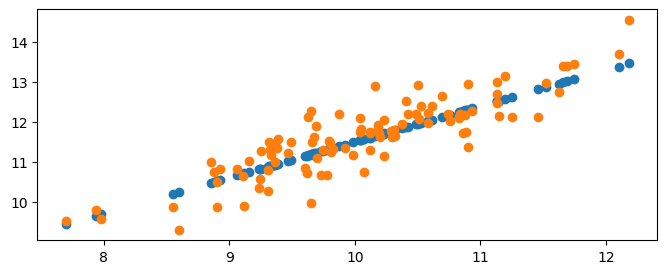

In [20]:
plt.scatter(x, y_real)
plt.scatter(x, y);

<Axes: xlabel='X', ylabel='Y'>

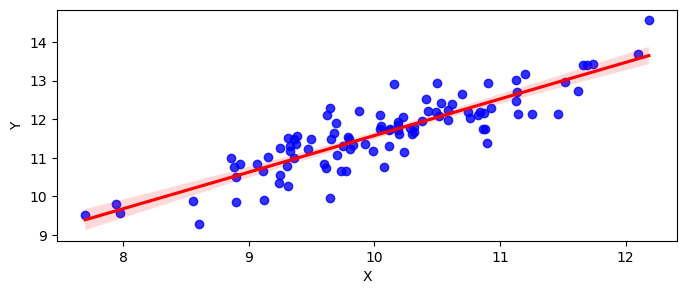

In [21]:
df = pd.DataFrame({"X": x, "Y": y})
sns.regplot(x="X", y="Y", data=df, scatter_kws={"color": "blue"}, line_kws={"color": "red"})

In [22]:
with pm.Model() as model_g:
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=1)
    sigma = pm.HalfCauchy("sigma", 5)
    #
    mu = pm.Deterministic("mu", alpha + beta * x)
    y_pred = pm.Normal("y_pred", mu=mu, sigma=sigma, observed=y)
    idata_g = pm.sample(2000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 5 seconds.


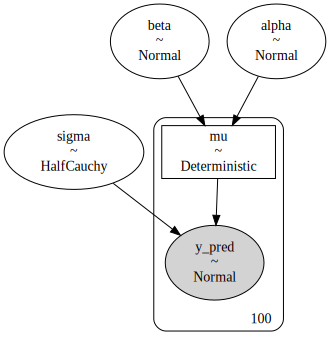

In [23]:
pm.model_to_graphviz(model_g)

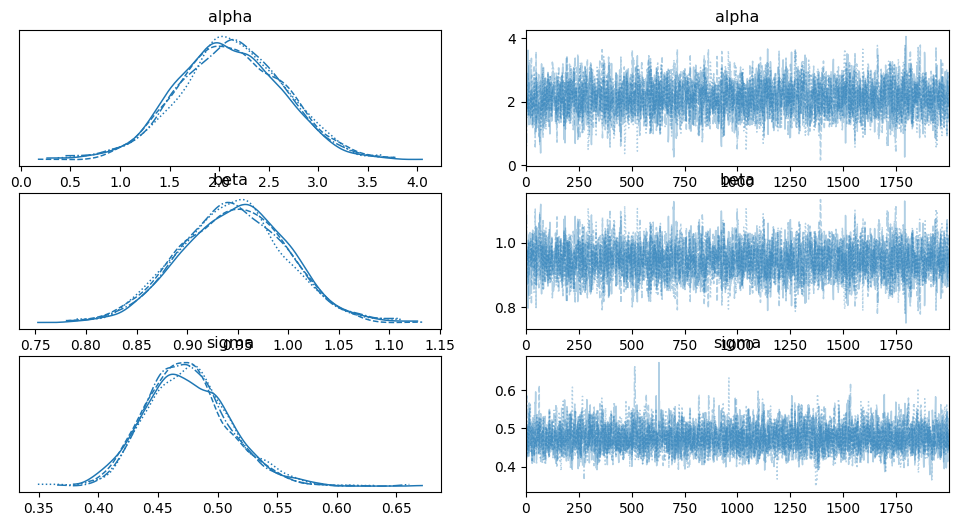

In [24]:
az.plot_trace(idata_g, var_names=["alpha", "beta", "sigma"]);

In [25]:
az.summary(idata_g, var_names="alpha beta sigma".split(), kind="stats")

,mean,sd,hdi_3%,hdi_97%
alpha,2.118,0.532,1.158,3.142
beta,0.946,0.053,0.842,1.038
sigma,0.475,0.035,0.410,0.539


## Bike rental example

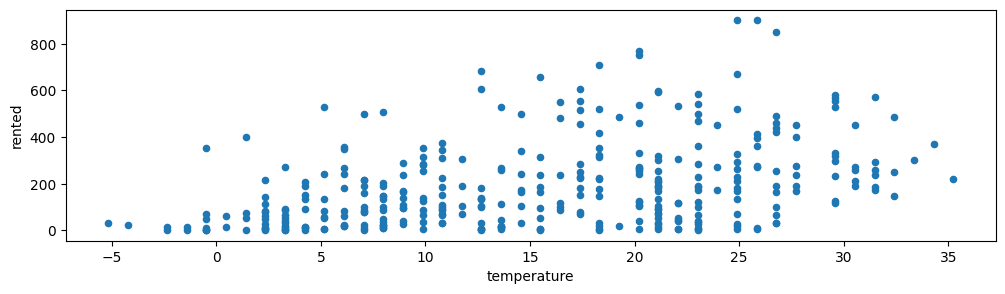

In [26]:
bikes = pd.read_csv(dir_name + "/bikes.csv")
bikes.plot(x="temperature", y="rented", figsize=(12, 3), kind="scatter");

In [27]:
bikes.head()

,rented,hour,temperature,humidity,windspeed,weekday
0,16,0,3.28,0.81,0.0000,6
1,3,5,-0.48,0.47,0.2836,1
2,115,9,2.34,0.37,0.3284,3
3,73,13,1.40,0.37,0.2836,5
4,82,15,2.34,0.35,0.3582,0


In [28]:
with pm.Model() as model_lb:
    alpha = pm.Normal("alpha", mu=0, sigma=100)
    beta = pm.Normal("beta", mu=0, sigma=10)
    sigma = pm.HalfCauchy("sigma", 10)
    #
    mu = pm.Deterministic("mu", alpha + beta * bikes.temperature)
    #
    y_pred = pm.Normal("y_pred", mu=mu, sigma=sigma, observed=bikes.rented)
    idata_lb = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


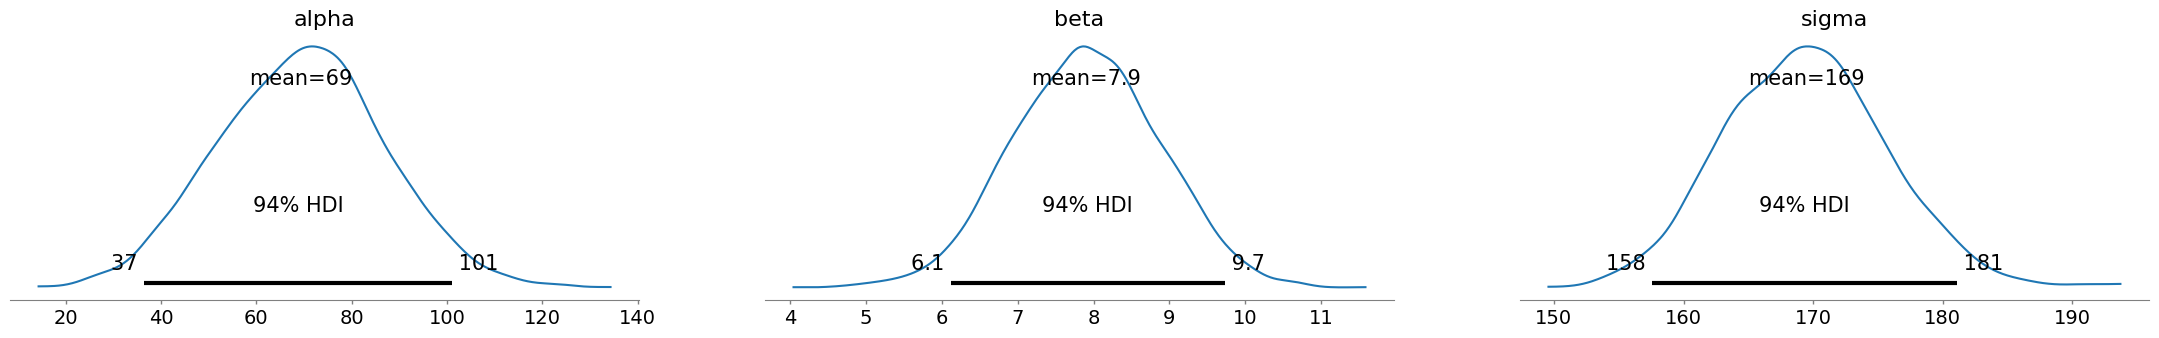

In [29]:
# Plot all the vars, excluding mu.
az.plot_posterior(idata_lb, var_names=["~mu"]);

In [30]:
# Sample from the posterior.
posterior = az.extract(idata_lb, num_samples=50)

In [31]:
# Create a data array of 50 equally-spaced points from min to max temperature along the `plot_id` axis.
x_plot = xr.DataArray(
    np.linspace(bikes.temperature.min(), bikes.temperature.max(), 50), dims="plot_id"
)

# Compute the expected value of the model for the points.
mean_line = posterior["alpha"].mean() + posterior["beta"].mean() * x_plot


# Compute 50 lines using the posterior.
lines = posterior["alpha"] + posterior["beta"] * x_plot

In [32]:
idata_lb_pp = pm.sample_posterior_predictive(idata_lb, model=model_lb)
mean_line = idata_lb.posterior["mu"].mean(("chain", "draw"))

def plot_data_and_model(bikes, idata):
    # Generate a vector with the temperatures and a bit of jitter.
    temperatures = np.random.normal(bikes.temperature.values, 0.01)
    
    # Sort in increasing order.
    idx = np.argsort(temperatures)
    
    # Sample the temperature intervals.
    x = np.linspace(temperatures.min(), temperatures.max(), 15)
    
    # Compute the quantiles, flattening over chain and draw.
    y_pred_q = idata.posterior_predictive["y_pred"].quantile(
        [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"])
    #obj_to_str(y_pred_q, only_schema=False)
    
    from scipy.interpolate import PchipInterpolator
    
    y_hat_bounds = [
            PchipInterpolator(temperatures[idx], y_pred_q[i][idx])(x)
            for i in range(4)
    ]
    #print(y_hat_bounds)
    
    # Plot the data set.
    plt.plot(bikes.temperature, bikes.rented, "C2.", zorder=-3)
    # Plot the mean.
    plt.plot(bikes.temperature[idx], mean_line[idx], c="C0")
    
    # Plot the quantiles.
    lb, ub = y_hat_bounds[0], y_hat_bounds[1]
    plt.fill_between(x, lb, ub, color="C1", alpha=0.2);
    lb, ub = y_hat_bounds[2], y_hat_bounds[3]
    plt.fill_between(x, lb, ub, color="C1", alpha=0.2);

Sampling: [y_pred]


Output()

In [33]:
print(x_plot.shape)

(50,)


In [34]:
print(mean_line.shape)

(348,)


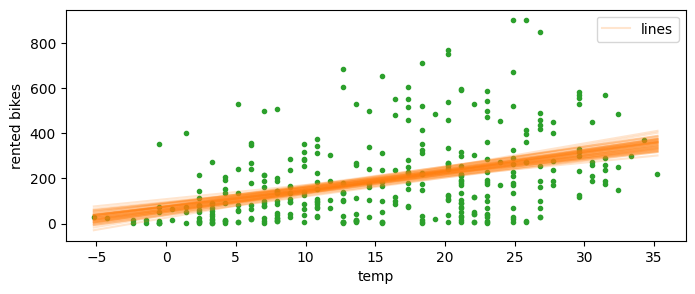

In [36]:
# - Plot the data
# zorder is to plot behind the line.
plt.plot(bikes.temperature, bikes.rented, "C2.", zorder=-3);

# - Plot the 50 models from the posterior.
# lines.T.values are the 50 lines.
lines_ = plt.plot(x_plot, lines.T.values, c="C1", alpha=0.2, label="lines");
# Remove the label for all the lines but the first one.
plt.setp(lines_[1:], label="_")

# Plot the mean line.
#plt.plot(x_plot, mean_line, c="C0", label="mean line");

plt.xlabel("temp")
plt.ylabel("rented bikes")

plt.legend();

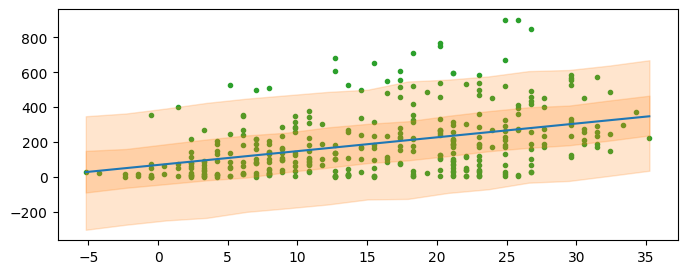

In [37]:
plot_data_and_model(bikes, idata_lb_pp)

## Counting

In [38]:
np.random.seed(42)
with pm.Model() as model_neg:
    alpha = pm.Normal("alpha", mu=0, sigma=100)
    beta = pm.Normal("beta", mu=0, sigma=10)
    # We use exp to have all positive numbers.
    mu = pm.Deterministic("mu", pm.math.exp(alpha + beta * bikes.temperature))
    # NegativeBinomial has an extra param alpha to control the variance.
    sigma = pm.HalfNormal("sigma", 10)
    y_pred = pm.NegativeBinomial("y_pred", mu=mu, alpha=sigma, observed=bikes.rented)
    #
    idata_neg = pm.sample()
    idata_neg.extend(pm.sample_posterior_predictive(idata_neg))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Sampling: [y_pred]


Output()

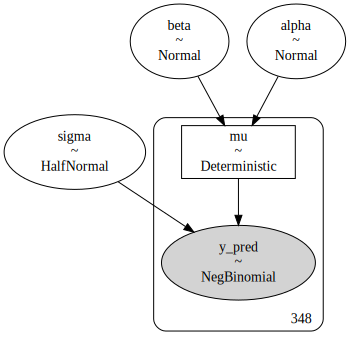

In [39]:
pm.model_to_graphviz(model_neg)

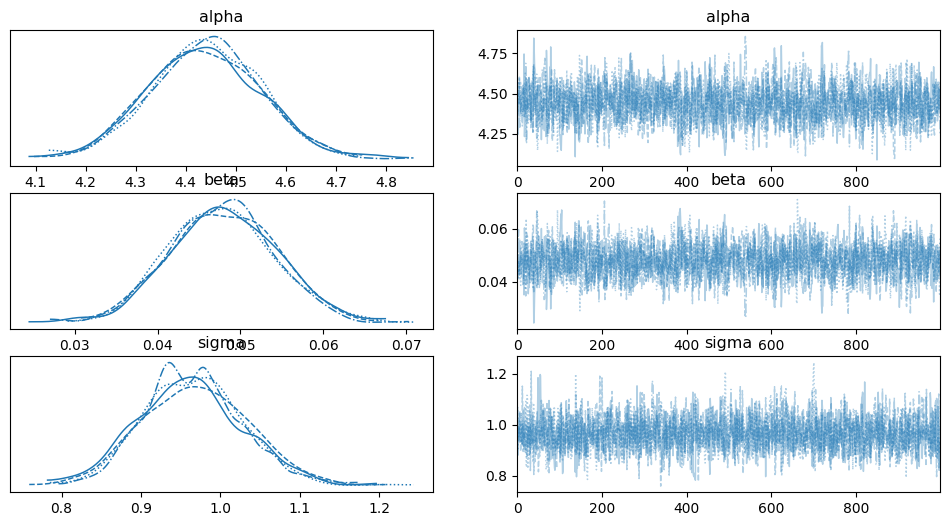

In [40]:
az.plot_trace(idata_neg, var_names=["~mu"]);

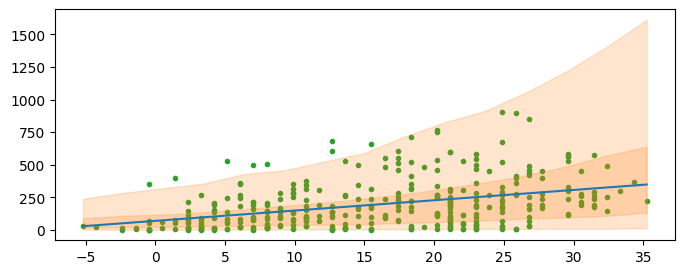

In [41]:
plot_data_and_model(bikes, idata_neg)

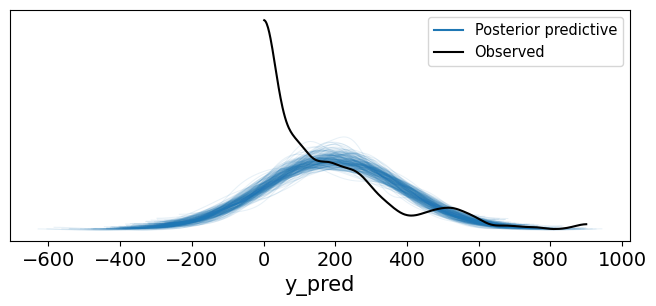

In [42]:
az.plot_ppc(
    idata_lb_pp,
    num_pp_samples=200,
    alpha=0.1,
    mean=False);

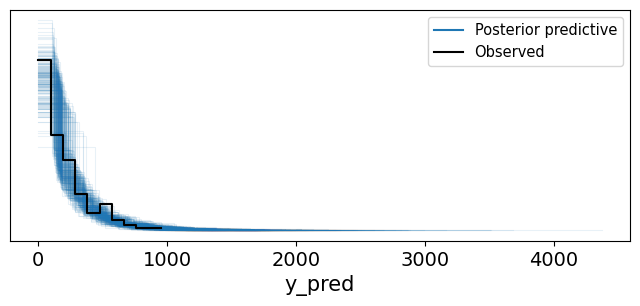

In [43]:
az.plot_ppc(
    idata_neg,
    num_pp_samples=200,
    alpha=0.1,
    mean=False);

## Robust regression

In [44]:
ans = pd.read_csv(dir_name + "/anscombe_3.csv")
display(ans.head())

,x,y
0,-4.891,5.713
1,-4.272,5.613
2,-3.126,6.430
3,-1.923,6.567
4,-0.502,7.246


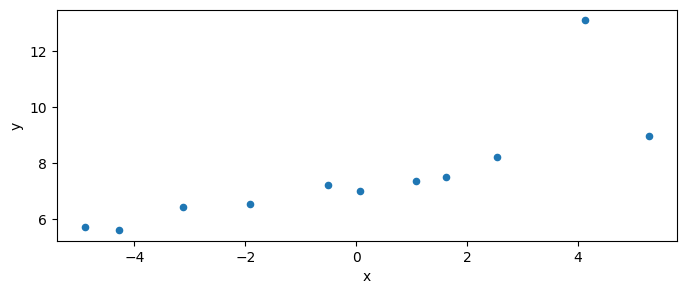

In [45]:
ans.plot("x", "y", kind="scatter");

![](lectures_source/figures/Lesson07_Non_robust_regression1.png)


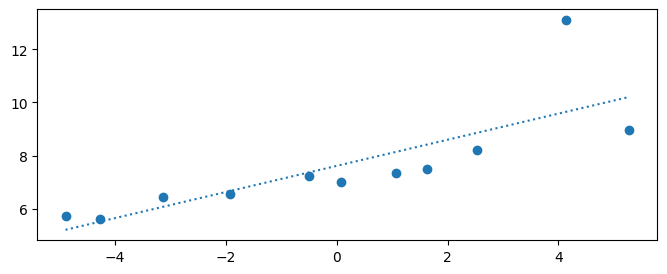

In [46]:
import scipy
from scipy.stats import linregress

beta_c, alpha_c, *_ = scipy.stats.linregress(ans.x, ans.y)

_, ax = plt.subplots()
ax.plot(ans.x, (alpha_c + beta_c * ans.x), "C0:", label="non-robust")
ax.plot(ans.x, ans.y, "C0o");

ut.save_ax(ax, "Lesson07_Non_robust_regression1.png")

In [47]:
with pm.Model() as model_t:
    # Alpha is normal centered around the mean of the y data.
    alpha = pm.Normal("alpha", mu=ans.y.mean(), sigma=1)
    # Beta is a standard (0, 1).
    beta = pm.Normal("beta", mu=0, sigma=1)
    sigma = pm.HalfNormal("sigma", 5)
    # The exponential puts too much weight close to 0, so we shift by 1.
    nu_ = pm.Exponential("nu_", 1/29)
    nu = pm.Deterministic("nu", nu_ + 1)

    # Model.
    mu = pm.Deterministic("mu", alpha + beta * ans.x)
    y_pred = pm.StudentT("y_pred", mu=mu, sigma=sigma, nu=nu, observed=ans.y)
    idata_t = pm.sample(2000, tune=2000)

    idata_t.extend(pm.sample_posterior_predictive(idata_t))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma, nu_]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 2 seconds.
Sampling: [y_pred]


Output()

In [48]:
#dot = pm.model_to_graphviz(model_t)
ut.save_dot(model_t, "Lesson07_Robust_regression_model")

![](lectures_source/figures/Lesson07_Robust_regression_model)


,mean,sd,hdi_3%,hdi_97%
alpha,7.21,0.14,6.96,7.42
beta,0.33,0.05,0.24,0.40
sigma,0.32,0.22,0.09,0.63
nu,2.64,5.50,1.00,4.36


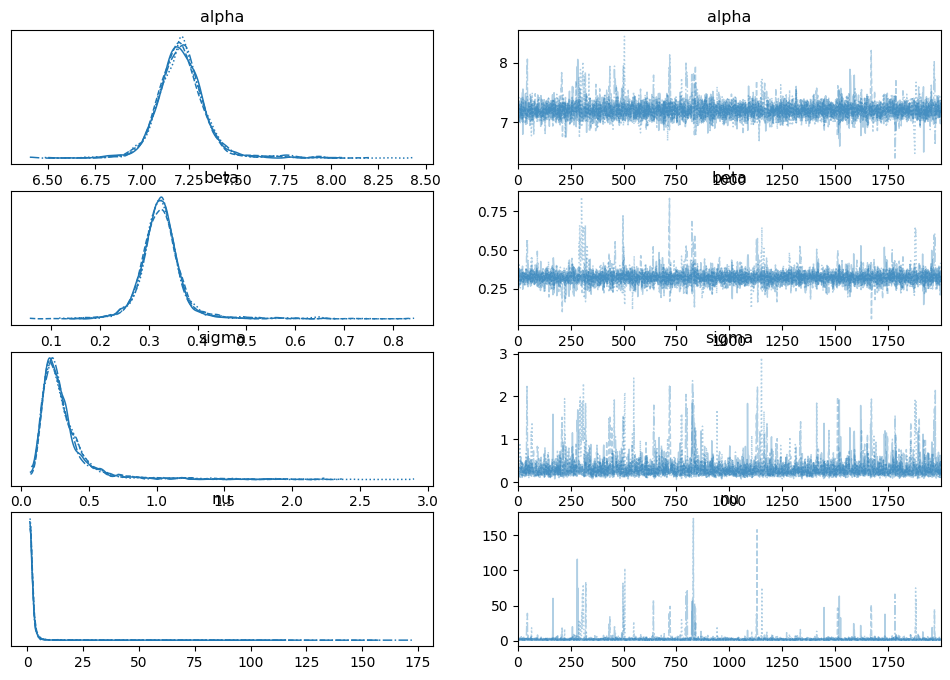

In [49]:
var_names = "alpha beta sigma nu".split()
az.plot_trace(idata_t, var_names=var_names);
az.summary(idata_t, var_names=var_names, round_to=2, kind="stats")

![](lectures_source/figures/Lesson07_Non_robust_regression2)


/venv/lib/python3.12/site-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


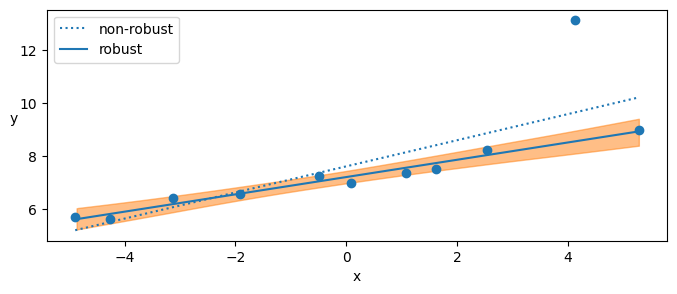

In [50]:
_, ax = plt.subplots()

# Non-robust.
ax.plot(ans.x, (alpha_c + beta_c * ans.x), "C0:", label="non-robust")
ax.plot(ans.x, ans.y, "C0o")

# Robust.
alpha_m = idata_t.posterior["alpha"].mean(("chain", "draw"))
beta_m = idata_t.posterior["beta"].mean(("chain", "draw"))

x_plot = xr.DataArray(np.linspace(ans.x.min(), ans.x.max(), 50), dims="plot_id")
ax.plot(x_plot, alpha_m + beta_m * x_plot, c="C0", label="robust")
az.plot_hdi(ans.x, az.hdi(idata_t.posterior["mu"])["mu"].T, ax=ax)
ax.set_xlabel("x")
ax.set_ylabel("y", rotation=0)
ax.legend(loc=2);

ut.save_ax(ax, "Lesson07_Non_robust_regression2")

In [51]:
#?pm.sample_posterior_predictive
#?az.plot_ppc

Sampling: [y_pred]


Output()

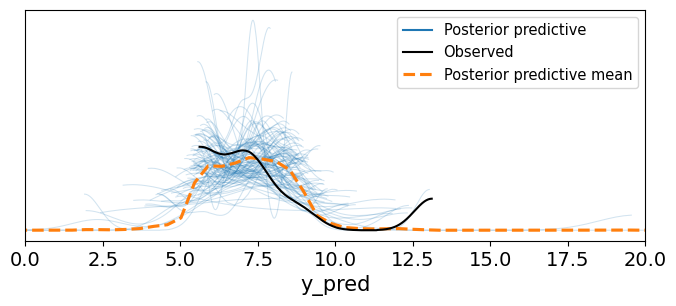

In [52]:
# Posterior predictive check.
ppc = pm.sample_posterior_predictive(idata_t,
                                     #samples=200,
                                     model=model_t,
                                     random_seed=2)
az.plot_ppc(idata_t, mean=True, num_pp_samples=100);
plt.xlim(0, 20);

## Logistic regression

In [53]:
iris = pd.read_csv(dir_name + "/iris.csv")
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [54]:
ut.save_df(iris.head(), "Lesson07_Logistic_regression_df.png")

![](lectures_source/figures/Lesson07_Logistic_regression_df.png)


In [55]:
# Filter the dataframe keeping only 2 values for species.
df = iris.query("species == ('setosa', 'versicolor')")
df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [56]:
# Get the predicted variable.
y_0 = pd.Categorical(df["species"]).codes
y_0

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int8)

In [57]:
# Get the sepal length as feature.
x_n = "sepal_length"
x_0 = df[x_n].values
x_c = x_0 - x_0.mean()

In [ ]:
with pm.Model() as model_lrs:
    # Linear part.
    alpha = pm.Normal("alpha", mu=0, sigma=1)
    beta = pm.Normal("beta", mu=0, sigma=5)
    mu = alpha + x_c * beta
    # Sigmoid.
    theta = pm.Deterministic("theta", pm.math.sigmoid(mu))
    # Model.
    yl = pm.Bernoulli("yl", p=theta, observed=y_0)
    # Intercept?
    bd = pm.Deterministic("bd", - alpha / beta)
    #
    idata_lrs = pm.sample(random_seed=123)

In [ ]:
ut.save_dot(model_lrs, "Lesson07_Logistic_regression_model.png")

In [ ]:
var_names = ["~bd", "~theta"]
az.summary(idata_lrs, var_names=var_names, round_to=2, kind="stats")

In [ ]:
ax = az.plot_trace(idata_lrs, var_names=var_names)

In [ ]:
ut.save_fig(ax, "Lesson07_Logistic_regression_result.png")

In [ ]:
posterior = idata_lrs.posterior
theta = posterior["theta"].mean(("chain", "draw"))
idx = np.argsort(x_c)
#print(posterior)
#print(idx)

# Plot the model.
_, ax = plt.subplots()
ax.plot(x_c[idx], theta[idx], color="C0", lw=2)

# Plot the decision.
ax.vlines(posterior["bd"].mean(("chain", "draw")), 0, 1, color="C2", zorder=0)
bd_hdi = az.hdi(posterior["bd"])
ax.fill_betweenx([0, 1], bd_hdi["bd"][0], bd_hdi["bd"][1], color="C2", alpha=0.6, lw=0)

# Plot the data.
ax.scatter(x_c, np.random.normal(y_0, 0.02), marker=".")

az.plot_hdi(x_c, posterior["theta"], color="C0", ax=ax)

save_ax(ax, "Lesson07_Logistic_regression_result2.png")

## Variable variance

In [ ]:
# Load data.
data = pd.read_csv(dir_name + "/babies.csv")
data.columns = ["month", "length"]
data.plot.scatter("month", "length");
display(data.head())

In [ ]:
ax = data.plot.scatter("month", "length")
save_ax(ax, "Lesson07_Variable_variance_data.png")

In [ ]:
with pm.Model() as model_vv:
    # Create a shared variable so that the data can change after the model is created.
    x_shared = pm.Data("x_shared", data.month.values.astype(float))
    # Linear model for the mean is a function of sqrt(x).
    alpha = pm.Normal("alpha", sigma=10)
    beta = pm.Normal("beta", sigma=10)
    mu = pm.Deterministic("mu", alpha + beta * x_shared ** 0.5)
    # Linear model for the std dev.
    gamma = pm.HalfNormal("gamma", sigma=10)
    delta = pm.HalfNormal("delta", sigma=10)
    sigma = pm.Deterministic("sigma", gamma + delta * x_shared)
    # Fit.
    y_pred = pm.Normal("y_pred", mu=mu, sigma=sigma, observed=data.length)
    #
    idata_vv = pm.sample(random_seed=123)

In [ ]:
pm.model_to_graphviz(model_vv)

In [ ]:
save_dot(model_vv, "Lesson07_Variable_variance_model.png")

In [ ]:
# Plot the data.
plt.plot(data.month, data.length, "C0.", alpha=0.1)

# Compute the posterior mean and sigma.
posterior = az.extract(idata_vv)
mu_m = posterior["mu"].mean("sample").values
sigma_m = posterior["sigma"].mean("sample").values

# Plot 1 and 2 std dev of the model.
plt.plot(data.month, mu_m, c="k")
plt.fill_between(data.month, mu_m + 1 * sigma_m, mu_m - 1 * sigma_m, alpha=0.6, color="C1")
plt.fill_between(data.month, mu_m + 2 * sigma_m, mu_m - 2 * sigma_m, alpha=0.4, color="C1")

save_plt("Lesson07_Variable_variance_result.png")

# Multiple linear regression

## Synthetic example

In [ ]:
np.random.seed(314)

N = 100
#N = 1000
alpha_real = 2.5
beta_real = [0.9, 1.5]
eps_stddev_real = 0.5
eps_real = np.random.normal(0, eps_stddev_real, size=N)

# Independent variables.
X = np.array([np.random.normal(i, j, N) for i, j in zip(
    # mean of gaussian.
    [10, 2],
    # std dev.
    [1, 1.5])]).T
X_mean = X.mean(axis=0, keepdims=True)
X_centered = X - X_mean

# Create samples.
y = alpha_real + np.dot(X, beta_real) + eps_real

In [ ]:
def scatter_plot(x, y):
    #plt.figure(figsize=(10, 10))
    # Plot y vs [x_1, x_2].
    for idx, x_i in enumerate(x.T):
        plt.subplot(2, 2, idx + 1)
        plt.scatter(x_i, y)
        plt.xlabel(f'x_{idx+1}')
        plt.ylabel(f'y', rotation=0)
    # Plot x_2 vs x_1.
    plt.subplot(2, 2, idx + 2)
    plt.scatter(x[:, 0], x[:, 1])
    plt.xlabel(f'x_{idx}')
    plt.ylabel(f'x_{idx+1}', rotation=0)


scatter_plot(X_centered, y)
ut.save_plt("Lesson07_Multiple_linear_regression3.png")

In [ ]:
with pm.Model() as model_mlr:
    alpha_tmp = pm.Normal('alpha_tmp', mu=0, sigma=10)
    # Beta is a vector.
    beta = pm.Normal('beta', mu=0, sigma=1, shape=2)
    eps = pm.HalfCauchy('eps', 5)
    # mu.
    mu = alpha_tmp + pm.math.dot(X_centered, beta)
    # Extract alpha.
    alpha = pm.Deterministic('alpha', alpha_tmp - pm.math.dot(X_mean, beta))
    
    # Model.
    y_pred = pm.Normal('y_pred', mu=mu, sigma=eps, observed=y)
    
    idata_mlr = pm.sample(2000)

In [ ]:
ut.save_dot(model_mlr, "Lesson07_Multiple_linear_regression_model.png")
pm.model_to_graphviz(model_mlr)

In [ ]:
var_names = ["alpha", "beta", "eps"]
az.plot_trace(idata_mlr, var_names=var_names);
ut.save_plt("Lesson07_Multiple_linear_regression_results1.png")

In [ ]:
df = az.summary(idata_mlr, var_names=var_names, round_to=2, kind="stats")
ut.save_df(df, "Lesson07_Multiple_linear_regression_results2.png")
df

## Rented bikes

In [ ]:
with pm.Model() as model_mlb:
    alpha = pm.Normal("alpha", mu=0, sigma=1)
    beta0 = pm.Normal("beta0", mu=0, sigma=10)
    beta1 = pm.Normal("beta1", mu=0, sigma=10)
    sigma = pm.HalfNormal("sigma", 10)
    mu = pm.Deterministic("mu", pm.math.exp(alpha + beta0 * bikes.temperature +
    beta1 * bikes.hour))
    _ = pm.NegativeBinomial("y_pred", mu=mu, alpha=sigma, observed=bikes.rented)
    #
    idata_mlb = pm.sample()

In [ ]:
pm.model_to_graphviz(model_mlb)

In [ ]:
ut.save_dot(model_mlb, "Lesson07_Multiple_linear_regression_model_RentedBikes_model.png")

In [ ]:
var_names = ["alpha", "beta0", "beta1", "sigma"]
az.plot_trace(idata_mlb, var_names=var_names);
ut.save_plt("Lesson07_Multiple_linear_regression_model_RentedBikes_model_trace.png")

In [ ]:
df = az.summary(idata_mlb, var_names=var_names, round_to=2, kind="stats")
df